# Imports

In [ ]:
import numpy as np
from scipy.special import expit   # sigmoid

import math
import numpy as np
import matplotlib.pyplot as plt
from time import time

import torch
from torchvision import datasets, transforms
import itertools


# Restricted Boltzmann Machine (RBM) for MNIST


Given $P_{data}(v)$, we approximate $P_{data}(v)$ using $P_{\theta}(v)$ where probability distribution is given by the Boltzmann distribution $P_{\theta}(v) = \frac{1}{Z} \exp \left( -E(v, h) \right)$ where the energy function $E(v, h)$ is:

$$
E(v, h) = -\sum_{i=1}^{n} \sum_{j=1}^{m} v_i W_{ij} h_j - \sum_{i=1}^{n} v_i b_i - \sum_{j=1}^{m} h_j c_j
$$

Where:
- $v \in [0, 1]^n$ are the visible units (input),
- $h \in \{0, 1\}^m$ are the hidden units,
- $W_{ij}$ is the weight matrix connecting visible and hidden units,
- $b_i$ are the biases for visible units,
- $c_j$ are the biases for hidden units.


The objective is to maximize the log-likelihood of the data distribution:$
\text{max}_{\theta} \left[ \ln P_{\theta}(v) \right] $.The gradient of the log-likelihood is approximated using Contrastive Divergence (CD):

$$
\nabla_{\theta} \left( -\ln P_{\theta}(v) \right) \approx \nabla_{\theta} E_{\theta}(v, h) - \nabla_{\theta} E_{\theta}(v', h')
$$

Where:
- $v'$ and $h'$ are reconstructions generated by the model (using Gibbs sampling),
- $\eta$ is the learning rate.


The learnable parameters $W, b, c$ are updated using the following gradients:

$$
\frac{\partial L(\theta)}{\partial W_{ij}} = \langle v_i h_j \rangle_{\text{data}} - \langle v_i h_j \rangle_{\text{model}}
$$

$$
\frac{\partial L(\theta)}{\partial b_i} = \langle v_i \rangle_{\text{data}} - \langle v_i \rangle_{\text{model}}
$$

$$
\frac{\partial L(\theta)}{\partial c_j} = \langle h_j \rangle_{\text{data}} - \langle h_j \rangle_{\text{model}}
$$

Where:
- $\langle v_i h_j \rangle_{\text{data}}$ is the expectation of visible-hidden unit pairs computed from the data,
- $\langle v_i h_j \rangle_{\text{model}}$ is the expectation under the model's reconstruction.

## Probability Distributions for Gibbs Sampling

We use the following conditional distributions in Gibbs sampling:

$$
P(h_j = 1 | v) = \sigma \left( \sum_{i=1}^{n} v_i W_{ij} + c_j \right)
$$

$$
P(v_i = 1 | h) = \sigma \left( \sum_{j=1}^{m} h_j W_{ij} + b_i \right)
$$

Where $\sigma(x)$ is the sigmoid activation function. These distributions are used to sample the hidden and visible layers during the reconstruction phase.

### Summary of Training Process

Training an RBM involves alternating between positive and negative phases using Contrastive Divergence (CD):
1. **Positive phase**: Compute the expectations from the data $\langle v_i h_j \rangle_{\text{data}}$.
2. **Negative phase**: Perform Gibbs sampling and compute the expectations under the model's reconstruction $\langle v_i h_j \rangle_{\text{model}}$.
3. **Parameter updates**: Update the weights and biases using the computed gradients from both phases.

### Defining our RBM Model

I have commented each part explicitly for ease and the architecture follows from the theory. However, let  explain parts that are novel.

#### Momentum-Based Optimization

We use velocities for each parameter to perform momentum-based updates. This helps smooth out oscillations and accelerates convergence by accumulating gradients over time. This explain the code under `Velocities - for momentum`. Below are the three associated equations for the weights, visible biases, and hidden biases. The velocity update for the weights \( W \) is:

$$
W_{\text{vel}, t+1} = \mu W_{\text{vel}, t} + (1 - \mu) \eta \frac{\partial L(\theta)}{\partial W}
$$

The weights are then updated using this velocity:

$$
W_{t+1} = W_t + W_{\text{vel}, t+1}
$$

Where:
- $ \mu $ is the momentum coefficient,
- $ \eta $ is the learning rate,
- $ \frac{\partial L(\theta)}{\partial W} $ is the gradient of the loss with respect to the weights.


The visible bias and the hidden biases are updated accordinly.


#### Bernoulli Sampling

In the RBM, we compute the probabilities for the hidden units being active given the visible units, and then sample from a Bernoulli distribution to decide whether each hidden unit is turned "on" (1) or "off" (0). Assume we have a batch of 3 visible vectors (with 4 visible units each) and 2 hidden units. After applying the sigmoid function, the probabilities for each hidden unit being active are as follows:

$$
P(h | v) = \begin{bmatrix}
0.8 & 0.3 \\
0.5 & 0.7 \\
0.2 & 0.9
\end{bmatrix}
$$

Where:
- Each row corresponds to a visible vector,
- Each column corresponds to a hidden unit.

For example, in the first row:
- The first hidden unit has a probability of 0.8 of being active,
- The second hidden unit has a probability of 0.3 of being active.


For each probability $ P(h_j = 1 | v) $, we sample from a **Bernoulli distribution**. The Bernoulli distribution generates a value of 1 (active) with probability $ P(h_j = 1 | v) $ and 0 (inactive) with probability $ 1 - P(h_j = 1 | v) $. The sampled activations might look like the following after Bernoulli:

$$
h = \begin{bmatrix}
1 & 0 \\
0 & 1 \\
0 & 1
\end{bmatrix}
$$

This means:
- For the first visible vector, the first hidden unit is "on" (1), and the second hidden unit is "off" (0).
- For the second visible vector, the first hidden unit is "off" (0), and the second hidden unit is "on" (1).
- For the third visible vector, only the second hidden unit is "on" (1).



In [ ]:
class RBM():
    def __init__(self, n_vis=28*28, n_hid=100):
        self.n_vis = n_vis # visible_units
        self.n_hid = n_hid # hidden units
        # Parameters
        self.W = 0.1 * np.random.randn(n_vis, n_hid) # W_ij connects visible
                                                     # $& hidden units
        self.vbias = np.zeros(n_vis)
        self.hbias = -4.0 * np.ones(n_hid)

        # Gradients
        self.W_grad = np.zeros(self.W.shape)
        self.vbias_grad = np.zeros(n_vis)
        self.hbias_grad = np.zeros(n_hid)

        # Velocities - for momentum
        self.W_vel = np.zeros(self.W.shape)
        self.vbias_vel = np.zeros(n_vis)
        self.hbias_vel = np.zeros(n_hid)

    def h_given_v(self, v):
        '''
        input:
            - v: (batch_size, n_vis)
        output:
            - p(H|v) = sigmoid(W^Tv + hbias): (batch_size, n_hid)
            - samples from p(H|v): (batch_size, n_hid)
        '''
        p = expit(np.matmul(v, self.W) + self.hbias)
        return (p, np.random.binomial(1, p=p))

    def v_given_h(self, h):
        '''
        input:
            - h: (batch_size, n_hid)
        output:
            - p(V|h) = sigmoid(Wh + vbias): (batch_size, n_vis)
            - samples from p(V|h): (batch_size, n_vis)
        '''
        p = expit(np.matmul(h, self.W.T) + self.vbias)
        return (p, np.random.binomial(1, p=p))

    def compute_error_and_grads(self, batch, burn_in=0, num_steps=5, method="cd"):
        '''
        Function to compute the gradient of parameters and store in param_grad variables
        and reconstruction error.
        Implements CD-k with k = num_steps.
        input:
            - batch: (batch_size, n_vis)
            - burn_in: Number of burn in steps for Gibbs sampling
            - num_steps: Number of steps for Gibbs sampling chain to run (CD-k)
            - method: Method for computing gradients. Available options:
                    - "cd": Contrastive Divergence
        output:
            - recon_error: Reconstruction error
        '''
        b_size = batch.shape[0]
        v0 = batch.reshape(b_size, -1)

        # Positive Phase
        ph0, h0 = self.h_given_v(v0)

        W_grad = np.matmul(v0.T, ph0)  # Positive gradient term
        vbias_grad = np.sum(v0, axis=0)
        hbias_grad = np.sum(ph0, axis=0)

        # Negative Phase (CD-k with k = num_steps)
        pv = v0
        for _ in range(num_steps):
            ph, h = self.h_given_v(pv)  # Hidden given visible
            pv, v = self.v_given_h(ph)  # Visible given hidden

        # After k Gibbs steps
        phk, hk = self.h_given_v(pv)

        # Negative gradient term
        W_grad -= np.matmul(pv.T, phk)

        # Convert both to float64 before subtraction
        vbias_grad = vbias_grad.astype(np.float64)
        vbias_grad -= np.sum(pv.astype(np.float64), axis=0)

        hbias_grad = hbias_grad.astype(np.float64)
        hbias_grad -= np.sum(phk.astype(np.float64), axis=0)

        # Normalize gradients
        self.W_grad = W_grad / b_size
        self.hbias_grad = hbias_grad / b_size
        self.vbias_grad = vbias_grad / b_size

        # Reconstruction error (sum of squared errors)
        recon_err = np.mean(np.sum((v0 - pv) ** 2, axis=1), axis=0)
        return recon_err

    def update_params(self, lr, momentum=0):
        '''
        Function to update the parameters based on the stored gradients.
        input:
            - lr: Learning rate
            - momentum
        '''
        self.W_vel *= momentum
        self.W_vel += (1.-momentum) * lr * self.W_grad
        self.W += self.W_vel

        self.vbias_vel *= momentum
        self.vbias_vel += (1.-momentum) * lr * self.vbias_grad
        self.vbias += self.vbias_vel

        self.hbias_vel *= momentum
        self.hbias_vel += (1.-momentum) * lr * self.hbias_grad
        self.hbias += self.hbias_vel

    def reconstruct(self, v):
        '''
        Reconstructing visible units from given v.
        v -> h0 -> v1
        input:
            - v: (batch_size, n_vis)
        output:
            - prob of reconstructed v: (batch_size, n_vis)
        '''
        ph0, h0 = self.h_given_v(v)
        pv1, v1 = self.v_given_h(ph0)
        return pv1

    def avg_free_energy(self, v):
        '''
        Compute the free energy of v averaged over the batch.
        input:
            - v: (batch_size, n_vis)
        output:
            - average of free energy: where free energy = - v.vbias - Sum_j (log(1 + exp(hbias + v_j*W_:,j)) )
        '''
        x = self.hbias + np.matmul(v, self.W)
        free_energy_batch = -np.matmul(v, self.vbias) - np.sum(np.log(1 + np.exp(x)), axis=1)
        return np.mean(free_energy_batch)

    def gen_model_sample(self, start=None, num_iters=1000):
        '''
        Generate random samples of visible unit from the model using Gibbs sampling.
        input:
            - start: Any starting value of v.
            - num_iters: Number of iterations of Gibbs sampling.
        '''
        if(start is None):
            v = np.random.randn(self.n_vis)
        else:
            v = start
        for _ in range(num_iters):
            ph, h = rbm.h_given_v(v)
            pv, v = rbm.v_given_h(h)
        return v

### Training

In the following notebook, my main aim would be train an RBM from scratch on MNIST. Recall that MNIST has grayscale images of size 28 x 28. We would map it form 28 x 28 to a hidden dimension of size 100. I would be following the implementation [here](https://github.com/mr-easy/Restricted-Boltzmann-Machine/blob/master/RBM.py)

In [ ]:
import torch
from torchvision import datasets, transforms

# Define transformations for normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load MNIST dataset from torchvision
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Convert to numpy arrays
X_train = train_dataset.data.numpy().reshape(-1, 28 * 28)
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy().reshape(-1, 28 * 28)
y_test = test_dataset.targets.numpy()

# EXTREMELY IMPORTANT TO NORMALIZE
X_train = np.true_divide(X_train, 255)
X_test = np.true_divide(X_test, 255)

# Some hand-picked images for each class for plotting
selected_imgs = X_train[[1, 6, 5, 12, 26, 35, 62, 52, 46, 4]]

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:01<00:00, 5464509.72it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 159961.56it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1512294.01it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 3404920.24it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Train-val split
split = 0.1
indices = np.arange(len(X_train))
np.random.shuffle(indices)
print(type(X_train))
X_val = X_train[:int(split * X_train.shape[0])]
X_train = X_train[int(split * X_train.shape[0]):]
y_val = y_train[:int(split * y_train.shape[0])]
y_train = y_train[int(split * y_train.shape[0]):]

print("Number of training instances:\t", y_train.shape[0])
print("Number of validation instances:\t", y_val.shape[0])
print("Number of test instances:\t", y_test.shape[0])

<class 'numpy.ndarray'>
Number of training instances:	 54000
Number of validation instances:	 6000
Number of test instances:	 10000


epoch:1 	 error:24921.1913 	 training time:12.66 s
epoch:2 	 error:12655.3607 	 training time:25.28 s
epoch:3 	 error:11103.2587 	 training time:37.85 s
epoch:4 	 error:10318.7423 	 training time:50.33 s
epoch:5 	 error:9844.5472 	 training time:62.86 s
epoch:6 	 error:9527.8283 	 training time:75.33 s
epoch:7 	 error:9301.2405 	 training time:87.96 s
epoch:8 	 error:9125.4008 	 training time:100.44 s
epoch:9 	 error:8981.5089 	 training time:113.08 s
epoch:10 	 error:8863.8465 	 training time:124.89 s
epoch:11 	 error:8761.3303 	 training time:138.69 s
epoch:12 	 error:8675.0509 	 training time:150.52 s
epoch:13 	 error:8598.2372 	 training time:163.01 s
epoch:14 	 error:8528.2949 	 training time:175.65 s
epoch:15 	 error:8471.4299 	 training time:188.34 s
epoch:16 	 error:8418.9174 	 training time:200.99 s
epoch:17 	 error:8370.8046 	 training time:213.49 s
epoch:18 	 error:8326.9294 	 training time:225.95 s
epoch:19 	 error:8285.0146 	 training time:238.52 s
epoch:20 	 error:8247.86

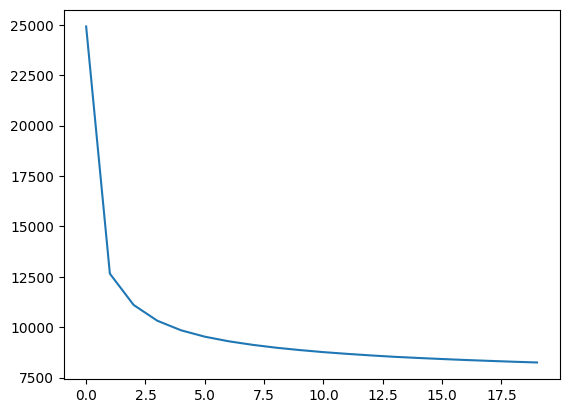

In [ ]:
# Function to provide data in batches
def get_batches(data, batch_size, shuffle=False):
    if shuffle:
        np.random.shuffle(data)
    if batch_size == -1:
        batch_size = len(data)
    num_batches = math.ceil(data.shape[0] / batch_size)
    for batch_num in range(num_batches):
        yield data[batch_num * batch_size:(batch_num + 1) * batch_size]

# Plotting functions (plot_images, plot_weights) remain unchanged

# Parameters for RBM
batch_size = 50
num_epochs = 20
lr = 0.1
burn_in = 0
num_steps = 1

# Assume RBM class is already implemented somewhere with methods like compute_error_and_grads and update_params
rbm = RBM(n_vis=28 * 28, n_hid=100)

# Training loop
errors = []
start_time = time()

for epoch in range(1, num_epochs + 1):
    iteration = 0
    error = 0
    for batch in get_batches(X_train, batch_size, shuffle=True):
        iteration += 1
        error += rbm.compute_error_and_grads(batch, burn_in=burn_in, num_steps=num_steps)

        # Update parameters - use momentum
        if epoch > 5:
            rbm.update_params(lr, momentum=0.5)
        else:
            rbm.update_params(lr, momentum=0.9)

    print(f"epoch:{epoch} \t error:{error:.4f} \t training time:{time()-start_time:.2f} s")
    errors.append(error)

# Plot error
plt.plot(errors)
plt.savefig("error_plot")



<Figure size 640x480 with 0 Axes>

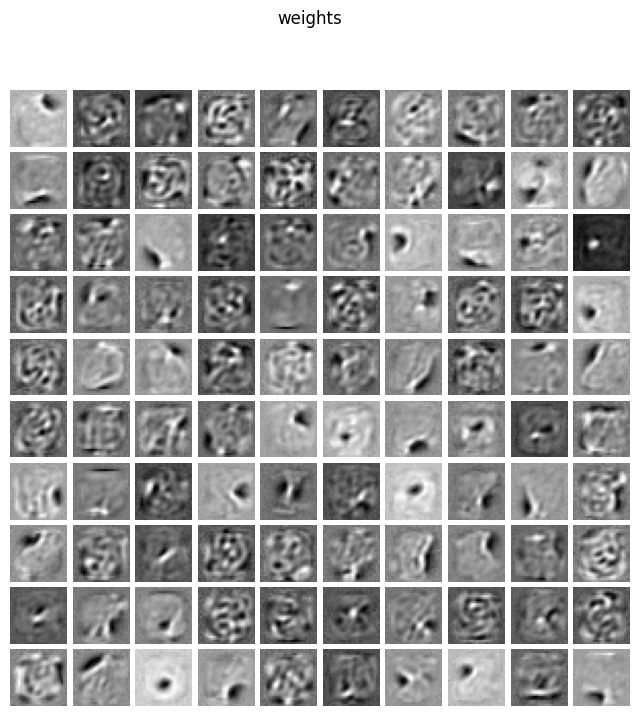

In [ ]:
def plot_weights(rbm, title='weights', save_as="weights"):
    '''
    Plot the weight parameter of the RBM, one for each hidden unit.
    '''
    plt.clf()
    fig, axes = plt.subplots(10, 10, gridspec_kw = {'wspace':0.1, 'hspace':0.1}, figsize=(8, 8))
    fig.suptitle(title)
    for i in range(10):
        for j in range(10):
            axes[i, j].imshow(rbm.W[:,i*10+j].reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')

    plt.savefig(save_as)
    plt.show()
    plt.close()
# Plot weights and images
plot_weights(rbm)

<Figure size 640x480 with 0 Axes>

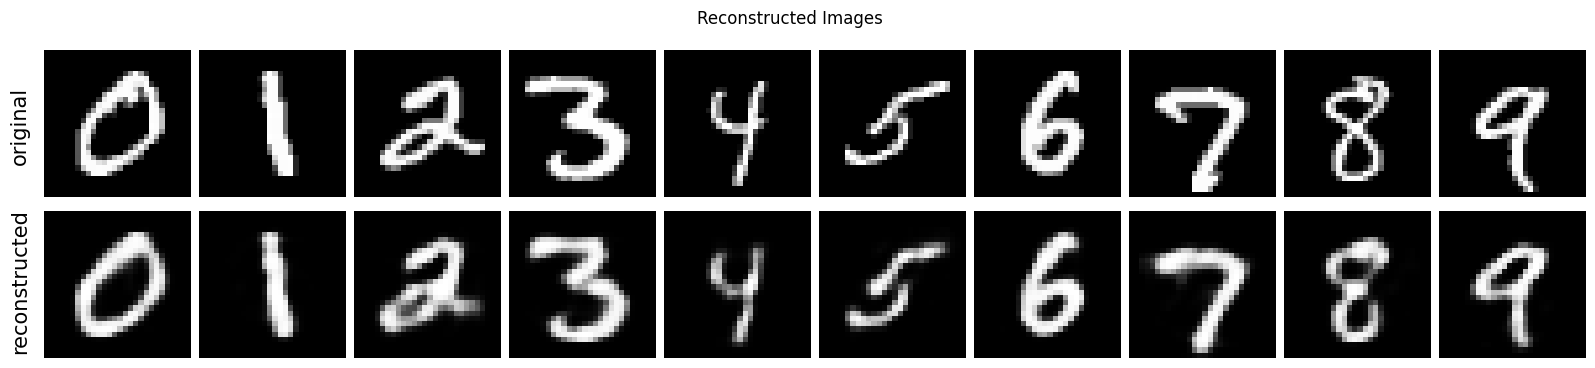

In [ ]:
def plot_images(rbm, images, title='Reconstructed Images', save_as="Reconstructed Images"):
    '''
    Plot the images and their reconstruction from RBM.
    input:
        - rbm: The RBM object to be used.
        - images: The images to be reconstructed (batch, 28, 28)
    '''
    num_samples = len(images)
    plt.clf()
    fig, axes = plt.subplots(2, num_samples, gridspec_kw = {'wspace':0, 'hspace':0.1}, figsize=(2*num_samples, 4))
    fig.suptitle(title)
    text = axes[0, 0].text(-7, 14,"original", size=15,
                           verticalalignment='center', rotation=-270)
    text = axes[1, 0].text(-7, 13,"reconstructed", size=15,
                           verticalalignment='center', rotation=-270)
    for n in range(num_samples):
        axes[0, n].imshow(images[n].reshape(28, 28), cmap='gray')
        axes[1, n].imshow(rbm.reconstruct(images[n].reshape(28*28)).reshape(28, 28), cmap='gray')
        axes[0, n].axis('off')
        axes[1, n].axis('off')

    plt.savefig(save_as)
    plt.show()
    plt.close()

plot_images(rbm, selected_imgs)

# RBMs for Thermodynamics

Let us try to implement the paper, *"Learning Thermodynamics with Boltzmann Machines"* by Giacomo Torlai and Roger. ## Boltzmann Distribution for a Spin System

The probability of a spin configuration $\sigma$ at temperature $T$ is given by the Boltzmann distribution: $p_s(\sigma, T) = \frac{1}{Z_S} \exp\left(-\frac{H_s(\sigma)}{T}\right)$  where the Hamiltonian $H_s(\sigma)$ is defined as:

$$H_s(\sigma) = -J \sum_{\langle i,j \rangle} \sigma_i \sigma_j$$


For a 1D chain with $N = 4$ spins, each spin interacts only with its nearest neighbors. The spin variables $\sigma_i$ take values from $\{-1, 1\}$, representing spins pointing either "up" (+1) or "down" (-1). We denote the spin configuration as: $\sigma = (\sigma_1, \sigma_2, \sigma_3, \sigma_4)$. For this system, the Hamiltonian $H_s(\sigma)$ can be written as: $H_s(\sigma) = -J \left( \sigma_1 \sigma_2 + \sigma_2 \sigma_3 + \sigma_3 \sigma_4 \right)$. The partition function $Z_S$ is the sum over all possible configurations of the system, normalizing the Boltzmann distribution:

$$Z_S = \sum_{\sigma} \exp\left(-\frac{H_s(\sigma)}{T}\right)$$

Since each spin can take either $+1$ or $-1$, there are $2^4 = 16$ possible configurations for the 4-spin system. In cases where $p_s(\sigma, T)$ is intractable, we can use Monte Carlo methods (e.g., Metropolis-Hastings) to sample spin configurations from the distribution.

The Monte Carlo algorithm works as follows:
1. **Initialize** the system with a random configuration of spins.
2. **Iteratively update** the system by flipping spins according to the following rule:
    - If flipping the spin **lowers the energy**, accept the move.
    - If flipping the spin **increases the energy**, accept the move with a probability that decreases with the energy difference and temperature $T$.
3. **Equilibration**: After some initial iterations, the system reaches equilibrium, where the configurations are representative of the Boltzmann distribution at temperature $T$.

After reaching equilibrium, store the generated spin configurations $\sigma_1, \sigma_2, \dots, \sigma_M$, where $M$ is the number of configurations. These spin configurations are used to train a Restricted Boltzmann Machine (RBM), which will learn the underlying distribution using these samples.


## RBM for Ising

When creating the RBM for Ising Model, we need to keep in mind that the ising model values are from {-1,1}. Thus, we must transform wherever we see -1 in our data to 0 before proceeding further because the RBM class that we created above was meant to handle binary data {0,1}. For the transformation above, we would utilize the binarizer from *sklearn*.

In [ ]:
import numpy as np
from scipy.special import expit

class RBM():
    def __init__(self, n_vis=6, n_hid=100):
        self.n_vis = n_vis # visible_units
        self.n_hid = n_hid # hidden units
        # Parameters
        self.W = 0.1 * np.random.randn(n_vis, n_hid) # W_ij connects visible
                                                     # $& hidden units
        self.vbias = np.zeros(n_vis)
        self.hbias = -4.0 * np.ones(n_hid)

        # Gradients
        self.W_grad = np.zeros(self.W.shape)
        self.vbias_grad = np.zeros(n_vis)
        self.hbias_grad = np.zeros(n_hid)

        # Velocities - for momentum
        self.W_vel = np.zeros(self.W.shape)
        self.vbias_vel = np.zeros(n_vis)
        self.hbias_vel = np.zeros(n_hid)

    def h_given_v(self, v):
        '''
        input:
            - v: (batch_size, n_vis)
        output:
            - p(H|v) = sigmoid(W^Tv + hbias): (batch_size, n_hid)
            - samples from p(H|v): (batch_size, n_hid)
        '''
        p = expit(np.matmul(v, self.W) + self.hbias)
        return (p, np.random.binomial(1, p=p))

    def v_given_h(self, h):
        '''
        input:
            - h: (batch_size, n_hid)
        output:
            - p(V|h) = sigmoid(Wh + vbias): (batch_size, n_vis)
            - samples from p(V|h): (batch_size, n_vis)
        '''
        p = expit(np.matmul(h, self.W.T) + self.vbias)
        return (p, np.random.binomial(1, p=p))

    def compute_error_and_grads(self, batch, burn_in=0, num_steps=5, method="cd"):
        '''
        Function to compute the gradient of parameters and store in param_grad variables
        and reconstruction error.
        Implements CD-k with k = num_steps.
        input:
            - batch: (batch_size, n_vis)
            - burn_in: Number of burn in steps for Gibbs sampling
            - num_steps: Number of steps for Gibbs sampling chain to run (CD-k)
            - method: Method for computing gradients. Available options:
                    - "cd": Contrastive Divergence
        output:
            - recon_error: Reconstruction error
        '''
        b_size = batch.shape[0]
        v0 = batch.reshape(b_size, -1)

        # Positive Phase
        ph0, h0 = self.h_given_v(v0)

        W_grad = np.matmul(v0.T, ph0)  # Positive gradient term
        vbias_grad = np.sum(v0, axis=0)
        hbias_grad = np.sum(ph0, axis=0)

        # Negative Phase (CD-k with k = num_steps)
        pv = v0
        for _ in range(num_steps):
            ph, h = self.h_given_v(pv)  # Hidden given visible
            pv, v = self.v_given_h(ph)  # Visible given hidden

        # After k Gibbs steps
        phk, hk = self.h_given_v(pv)

        # Negative gradient term
        W_grad -= np.matmul(pv.T, phk)

        # Convert both to float64 before subtraction
        vbias_grad = vbias_grad.astype(np.float64)
        vbias_grad -= np.sum(pv.astype(np.float64), axis=0)

        hbias_grad = hbias_grad.astype(np.float64)
        hbias_grad -= np.sum(phk.astype(np.float64), axis=0)

        # Normalize gradients
        self.W_grad = W_grad / b_size
        self.hbias_grad = hbias_grad / b_size
        self.vbias_grad = vbias_grad / b_size

        # Reconstruction error (sum of squared errors)
        recon_err = np.mean(np.sum((v0 - pv) ** 2, axis=1), axis=0)
        return recon_err

    def update_params(self, lr, momentum=0):
        '''
        Function to update the parameters based on the stored gradients.
        input:
            - lr: Learning rate
            - momentum
        '''
        self.W_vel *= momentum
        self.W_vel += (1.-momentum) * lr * self.W_grad
        self.W += self.W_vel

        self.vbias_vel *= momentum
        self.vbias_vel += (1.-momentum) * lr * self.vbias_grad
        self.vbias += self.vbias_vel

        self.hbias_vel *= momentum
        self.hbias_vel += (1.-momentum) * lr * self.hbias_grad
        self.hbias += self.hbias_vel

    def reconstruct(self, v):
        '''
        Reconstructing visible units from given v.
        v -> h0 -> v1
        input:
            - v: (batch_size, n_vis)
        output:
            - prob of reconstructed v: (batch_size, n_vis)
        '''
        ph0, h0 = self.h_given_v(v)
        pv1, v1 = self.v_given_h(ph0)
        return pv1

    def avg_free_energy(self, v):
        '''
        Compute the free energy of v averaged over the batch.
        input:
            - v: (batch_size, n_vis)
        output:
            - average of free energy: where free energy = - v.vbias - Sum_j (log(1 + exp(hbias + v_j*W_:,j)) )
        '''
        x = self.hbias + np.matmul(v, self.W)
        free_energy_batch = -np.matmul(v, self.vbias) - np.sum(np.log(1 + np.exp(x)), axis=1)
        return np.mean(free_energy_batch)

    def gen_model_sample(self, start=None, num_iters=1000):
        '''
        Generate random samples of visible unit from the model using Gibbs sampling.
        input:
            - start: Any starting value of v.
            - num_iters: Number of iterations of Gibbs sampling.
        '''
        if(start is None):
            v = np.random.randn(self.n_vis)
        else:
            v = start
        for _ in range(num_iters):
            ph, h = rbm.h_given_v(v)
            pv, v = rbm.v_given_h(h)
        return v


### Ising Hamiltonian for N = 6



#### Computing the exact Probability distribuition for N = 6
The authors begin by training one machine on a one-dimensional chain with 6 spins. The authors note that for such a small systems it is possible to compute the partition function, and thus the full probability distribution
exactly. We prepare a data set of configurations using
the exact probability distribution. Let us reproduct their result. Assuming periodic boundary conditions, the Hamiltonian assumes the form (J = 1):

$$H_s = \sigma_{1}\sigma_{2} + \sigma_{2}\sigma_{3} + \sigma_{3}\sigma_{4} + \sigma_{4}\sigma_{5} + \sigma_{5}\sigma_{6} + \sigma_{6}\sigma_{1} $$

Keep in mind that configurations where all spins are aligned lead to lower energies are more likey and vice-versa. We would like to solve this system exactly. For that, we need to evaluate the partition function $Z = \sum_{\sigma}{e^{H(\sigma)/T}} $. For N = 6 states, there are a total of $2^{N} = 64$ combinations possible. We now find these exactly.

In [ ]:
## Boltzmann Distribution for a Spin System

# Define parameters
N = 6  # Number of spins
J = 1  # Coupling constant
T = 1  # Temperature

# Generate all possible spin configurations (-1, 1 for each spin)
configurations = list(itertools.product([-1, 1], repeat=N))
print(configurations[1])
print(len(configurations)) # 64 configurations possible.

(-1, -1, -1, -1, -1, 1)
64


In [ ]:
# Hamiltonian function for 1D Ising model with periodic boundary conditions

# The function loops through each spin in the configuration.
# For each spin 𝜎_{𝑖} , it multiplies it by its nearest neighbor 𝜎_{i+1}
# The expression config[(i + 1) % N] ensures that when i is at the last spin in
# the chain, it wraps around to the first spin (periodic boundary condition)


def hamiltonian_periodic(config, J):
    energy = 0
    for i in range(len(config)):
        energy += config[i] * config[(i + 1) % N]  # Periodic boundary condition
    return -J * energy

def hamiltonian_non_periodic(config, J):
    energy = 0
    N = len(config)  # Length of the spin configuration
    for i in range(N - 1):  # No interaction between the last and the first spin
        energy += config[i] * config[i + 1]
    return -J * energy


# Example configuration and parameters
config = [-1, 1, -1, 1, -1, 1]  # Example spin configuration
J = 1  # Coupling constant

# Call the hamiltonian function
energy = hamiltonian_non_periodic(config, J)

# Output the energy
print(f"Energy of the configuration {config} is {energy}")

Energy of the configuration [-1, 1, -1, 1, -1, 1] is 5


In [ ]:
# Initialize lists for energies and Boltzmann factors
energies = []
boltzmann_factors = []

# Loop over each configuration
for config in configurations:
    # Compute the energy for the current configuration
    energy = hamiltonian_periodic(config, J)

    # Append the energy to the list
    energies.append(energy)

    # Compute the Boltzmann factor for the current energy
    boltzmann_factor = np.exp(-energy / T)

    # Append the Boltzmann factor to the list
    boltzmann_factors.append(boltzmann_factor)

# Convert lists to arrays for further computation (if needed)
energies = np.array(energies)
boltzmann_factors = np.array(boltzmann_factors)

In [ ]:
# Partition function Z
Z = np.sum(boltzmann_factors)

# Boltzmann probabilities for each configuration
probabilities = boltzmann_factors / Z

# Organize the result for better readability
results = []
for config, energy, prob in zip(configurations, energies, probabilities):
    results.append((config, energy, prob))

import pandas as pd
df = pd.DataFrame(results, columns=['Configuration', 'Energy', 'Boltzmann Probability'])

print(df)




               Configuration  Energy  Boltzmann Probability
0   (-1, -1, -1, -1, -1, -1)      -6               0.390694
1    (-1, -1, -1, -1, -1, 1)      -2               0.007156
2    (-1, -1, -1, -1, 1, -1)      -2               0.007156
3     (-1, -1, -1, -1, 1, 1)      -2               0.007156
4    (-1, -1, -1, 1, -1, -1)      -2               0.007156
..                       ...     ...                    ...
59       (1, 1, 1, -1, 1, 1)      -2               0.007156
60      (1, 1, 1, 1, -1, -1)      -2               0.007156
61       (1, 1, 1, 1, -1, 1)      -2               0.007156
62       (1, 1, 1, 1, 1, -1)      -2               0.007156
63        (1, 1, 1, 1, 1, 1)      -6               0.390694

[64 rows x 3 columns]


### Binarizing Data

We now binarize data from {-1,-1} to {0, 1}

In [ ]:
from sklearn.preprocessing import Binarizer  # Import the Binarizer

# Extract the Configuration column as a numpy array
configurations = np.array(df['Configuration'].tolist())

# Binarize the Configuration column (convert -1 to 0 and leave 1 as it is)
binarizer = Binarizer(threshold=0.0)
binary_configurations = binarizer.fit_transform(configurations)

# Replace the Configuration column in the DataFrame with the binarized configurations
df['Configuration'] = list(binary_configurations)

# Print the updated DataFrame
print(df)

         Configuration  Energy  Boltzmann Probability
0   [0, 0, 0, 0, 0, 0]      -6               0.390694
1   [0, 0, 0, 0, 0, 1]      -2               0.007156
2   [0, 0, 0, 0, 1, 0]      -2               0.007156
3   [0, 0, 0, 0, 1, 1]      -2               0.007156
4   [0, 0, 0, 1, 0, 0]      -2               0.007156
..                 ...     ...                    ...
59  [1, 1, 1, 0, 1, 1]      -2               0.007156
60  [1, 1, 1, 1, 0, 0]      -2               0.007156
61  [1, 1, 1, 1, 0, 1]      -2               0.007156
62  [1, 1, 1, 1, 1, 0]      -2               0.007156
63  [1, 1, 1, 1, 1, 1]      -6               0.390694

[64 rows x 3 columns]


#### Plotting the 1D ising model for N = 6

**Confusion** In the paper, the authors have shown the probabilities associated with degenerate states to be different and not equally likely. Is that a mistake or am I missing something? In particular, see figure 2B.

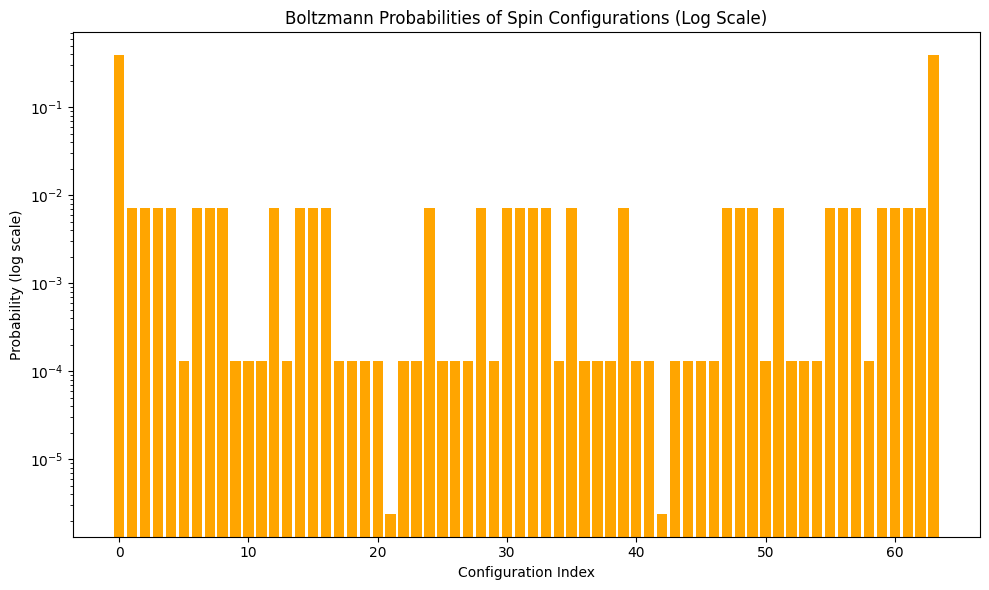

In [ ]:

# Plot the energies and corresponding Boltzmann probabilities on a log scale
plt.figure(figsize=(10, 6))

# Plot Boltzmann probabilities
plt.subplot(1, 1, 1)
plt.bar(range(len(probabilities)), probabilities, color='orange')
plt.yscale('log')  # Logarithmic scale for the probabilities
plt.title('Boltzmann Probabilities of Spin Configurations (Log Scale)')
plt.ylabel('Probability (log scale)')
plt.xlabel('Configuration Index')

# Show the plot
plt.tight_layout()
plt.show()

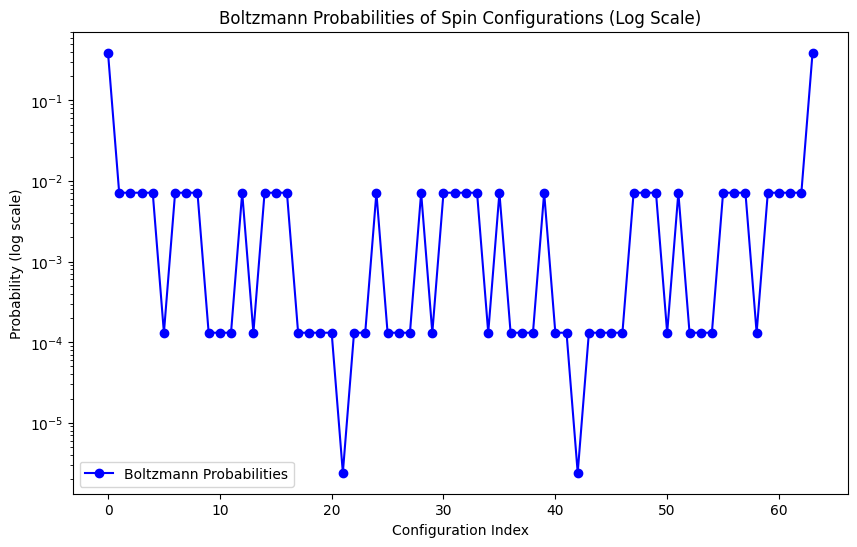

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate configuration indices (0 to 63 for N=6)
config_indices = range(len(configurations))

# Plotting the probabilities on a logarithmic scale
plt.figure(figsize=(10, 6))

# Plot the probabilities as a line plot
plt.plot(config_indices, probabilities, marker='o', linestyle='-', color='blue', label='Boltzmann Probabilities')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Labeling the plot
plt.title('Boltzmann Probabilities of Spin Configurations (Log Scale)')
plt.xlabel('Configuration Index')
plt.ylabel('Probability (log scale)')

# Show the legend
plt.legend()

# Show the plot
plt.show()

#### Train-Test Split

An RBM is a generative model trained in an unsupervised manner. Its goal is to learn the underlying probability distribution of the dataset, which in this case consists of different spin configurations. Since there are no labels or classification tasks involved, there's no need for a train-test split in the traditional sense.

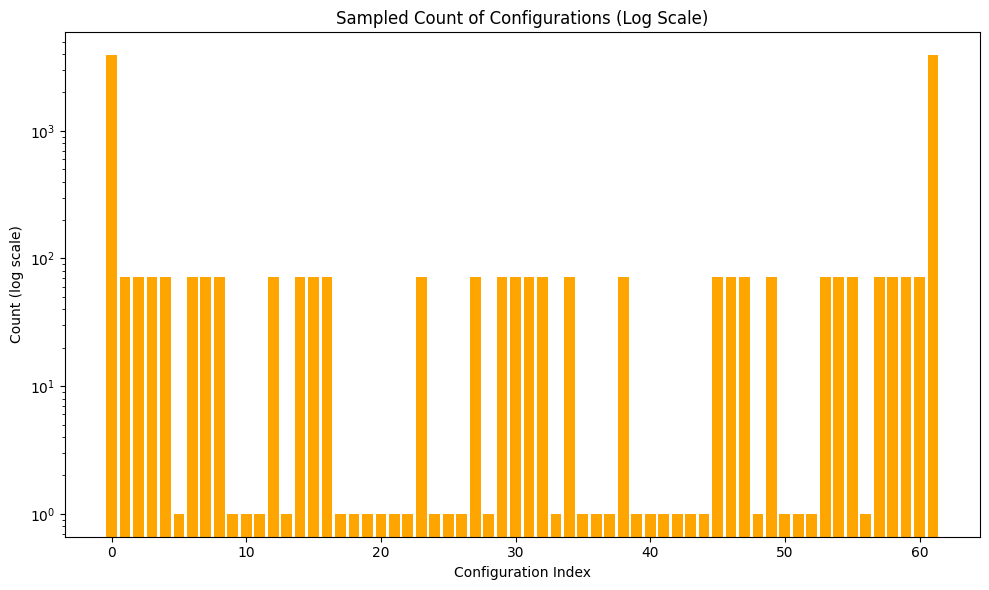

In [ ]:
from collections import Counter

# Total number of samples we want
num_samples = 10000

# Replicate each configuration proportional to its Boltzmann probability
df['Cloned Count'] = (df['Boltzmann Probability'] * num_samples).round().astype(int)

# Create a new list of configurations based on these counts
sampled_configs = []
for idx, row in df.iterrows():
    sampled_configs.extend([row['Configuration']] * row['Cloned Count'])

# Convert each configuration from numpy array to tuple to make it hashable
sampled_configs = [tuple(config) for config in sampled_configs]

# Now count the occurrences of each configuration
config_counts = Counter(sampled_configs)

# Separate the configurations and their counts for plotting
configs, counts = zip(*config_counts.items())

# Plot the sampled counts (count vs configuration)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(range(len(config_counts)), counts, color='orange')
plt.yscale('log')  # Logarithmic scale for the counts
plt.title('Sampled Count of Configurations (Log Scale)')
plt.ylabel('Count (log scale)')
plt.xlabel('Configuration Index')

plt.tight_layout()
plt.show()

In [ ]:
import random

# Create a new list of configurations based on these counts
sampled_configs = []
for idx, row in df.iterrows():
    sampled_configs.extend([row['Configuration']] * row['Cloned Count'])

# Ensure we have exactly 10000 samples (truncate any excess)
sampled_configs = sampled_configs[:num_samples]

# Convert sampled configurations to tuple and check counts
sampled_configs = [tuple(config) for config in sampled_configs]
config_counts = Counter(sampled_configs)

# Print the distribution of the sampled configurations
print("Configuration counts: ")
for config, count in config_counts.items():
    print(f"Config: {config}, Count: {count}")

# Shuffle the sampled configurations to randomize the order
random.shuffle(sampled_configs)

# Ensure we have exactly 10000 samples (truncate any excess)
sampled_configs = sampled_configs[:num_samples]
# Convert the sampled configurations list to a numpy array
dataset = np.array(sampled_configs)



Configuration counts: 
Config: (0, 0, 0, 0, 0, 0), Count: 3907
Config: (0, 0, 0, 0, 0, 1), Count: 72
Config: (0, 0, 0, 0, 1, 0), Count: 72
Config: (0, 0, 0, 0, 1, 1), Count: 72
Config: (0, 0, 0, 1, 0, 0), Count: 72
Config: (0, 0, 0, 1, 0, 1), Count: 1
Config: (0, 0, 0, 1, 1, 0), Count: 72
Config: (0, 0, 0, 1, 1, 1), Count: 72
Config: (0, 0, 1, 0, 0, 0), Count: 72
Config: (0, 0, 1, 0, 0, 1), Count: 1
Config: (0, 0, 1, 0, 1, 0), Count: 1
Config: (0, 0, 1, 0, 1, 1), Count: 1
Config: (0, 0, 1, 1, 0, 0), Count: 72
Config: (0, 0, 1, 1, 0, 1), Count: 1
Config: (0, 0, 1, 1, 1, 0), Count: 72
Config: (0, 0, 1, 1, 1, 1), Count: 72
Config: (0, 1, 0, 0, 0, 0), Count: 72
Config: (0, 1, 0, 0, 0, 1), Count: 1
Config: (0, 1, 0, 0, 1, 0), Count: 1
Config: (0, 1, 0, 0, 1, 1), Count: 1
Config: (0, 1, 0, 1, 0, 0), Count: 1
Config: (0, 1, 0, 1, 1, 0), Count: 1
Config: (0, 1, 0, 1, 1, 1), Count: 1
Config: (0, 1, 1, 0, 0, 0), Count: 72
Config: (0, 1, 1, 0, 0, 1), Count: 1
Config: (0, 1, 1, 0, 1, 0), Count: 1


epoch:1 	 error:298.6413 	 training time:0.48 s
epoch:2 	 error:296.6148 	 training time:1.08 s
epoch:3 	 error:223.6215 	 training time:1.58 s
epoch:4 	 error:93.2509 	 training time:2.10 s
epoch:5 	 error:62.0051 	 training time:2.56 s
epoch:6 	 error:58.0967 	 training time:3.07 s
epoch:7 	 error:57.1027 	 training time:3.63 s
epoch:8 	 error:56.3568 	 training time:4.08 s
epoch:9 	 error:55.2878 	 training time:4.31 s
epoch:10 	 error:53.8047 	 training time:4.47 s
epoch:11 	 error:52.1313 	 training time:4.63 s
epoch:12 	 error:50.2718 	 training time:4.79 s
epoch:13 	 error:47.9870 	 training time:4.97 s
epoch:14 	 error:45.1473 	 training time:5.14 s
epoch:15 	 error:41.7535 	 training time:5.34 s
epoch:16 	 error:38.2828 	 training time:5.50 s
epoch:17 	 error:35.1114 	 training time:5.66 s
epoch:18 	 error:32.0259 	 training time:5.82 s
epoch:19 	 error:28.8276 	 training time:5.99 s
epoch:20 	 error:25.3743 	 training time:6.17 s


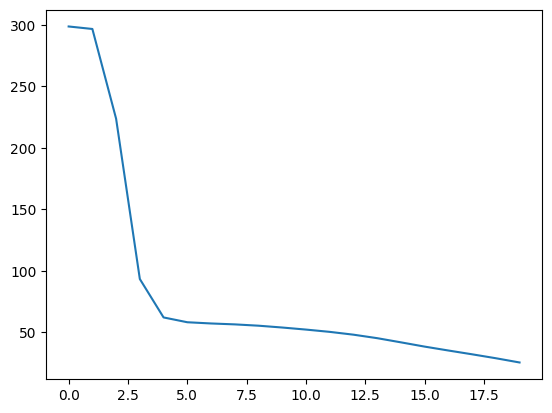

In [ ]:
# Function to provide data in batches
def get_batches(data, batch_size, shuffle=False):
    if shuffle:
        np.random.shuffle(data)
    if batch_size == -1:
        batch_size = len(data)
    num_batches = math.ceil(data.shape[0] / batch_size)
    for batch_num in range(num_batches):
        yield data[batch_num * batch_size:(batch_num + 1) * batch_size]

# Plotting functions (plot_images, plot_weights) remain unchanged

# Parameters for RBM
batch_size = 50
num_epochs = 20
lr = 0.1
burn_in = 0
num_steps = 1

# Assume RBM class is already implemented somewhere with methods like compute_error_and_grads and update_params
rbm = RBM(n_vis= 6, n_hid=40)

# Training loop
errors = []
start_time = time()

for epoch in range(1, num_epochs + 1):
    iteration = 0
    error = 0
    for batch in get_batches(dataset, batch_size, shuffle=True):
        iteration += 1
        error += rbm.compute_error_and_grads(batch, burn_in=burn_in, num_steps=num_steps)

        # Update parameters - use momentum
        if epoch > 5:
            rbm.update_params(lr, momentum=0.5)
        else:
            rbm.update_params(lr, momentum=0.9)

    print(f"epoch:{epoch} \t error:{error:.4f} \t training time:{time()-start_time:.2f} s")
    errors.append(error)

# Plot error
plt.plot(errors)
plt.savefig("error_plot")

#### Train

In [ ]:
from collections import Counter

# Generate samples from the RBM after training
num_samples = 10000  # Number of samples to generate
samples = np.array([rbm.gen_model_sample() for _ in range(num_samples)])


# Count occurrences of each unique configuration
config_counter = Counter(tuple(samples) for samples in samples)

# Normalize the counts to get probabilities
rbm_approx_prob = {config: count / num_samples for config, count in config_counter.items()}
#print("Generated Samples: ", samples[:10])
#print("Approximate Probabilities: ", list(rbm_approx_prob.items())[:5])


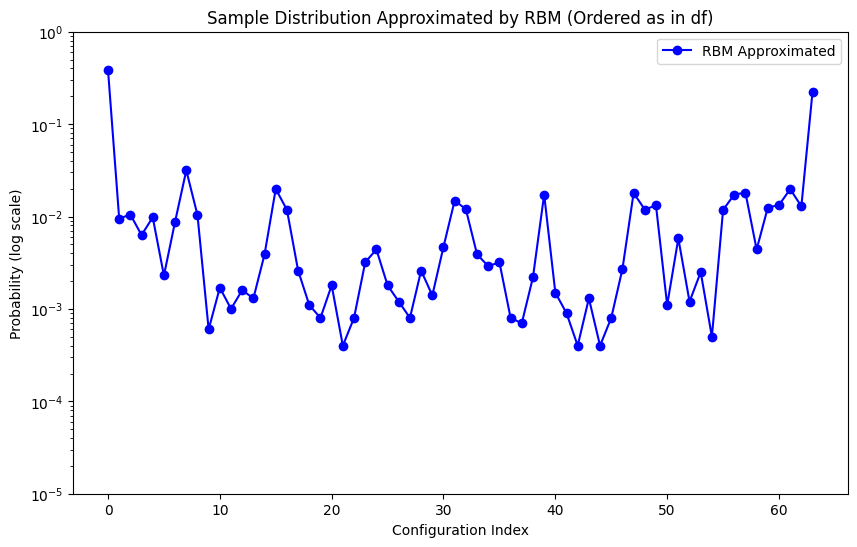

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df['Configuration'] contains the ordered configurations and binary_configurations is already binarized
# Convert the configurations in df to tuples so they can be used for lookup in the RBM probabilities
ordered_configurations = [tuple(config) for config in df['Configuration'].tolist()]

# Convert the RBM learned distribution to arrays for plotting
# If a configuration doesn't exist in rbm_approx_prob, it gets a probability of 0
approx_probs = np.array([rbm_approx_prob.get(config, 0) for config in ordered_configurations])

# Plot the RBM learned distribution in the same order as df
plt.figure(figsize=(10, 6))

# Plot RBM approximated distribution
plt.plot(range(len(ordered_configurations)), approx_probs, marker='o', linestyle='-', color='blue', label='RBM Approximated')

# Set the y-axis to log scale for better visualization and limit from 10^0 to 10^-5
plt.yscale('log')
plt.ylim(1e-5, 1)

# Add title and labels
plt.title('Sample Distribution Approximated by RBM (Ordered as in df)')
plt.xlabel('Configuration Index')
plt.ylabel('Probability (log scale)')
plt.legend()

# Show the plot
plt.show()